In [187]:
from eda import get_objectives, get_constraints, non_dominated_sort, non_dominated, assign_crowding_distance, binary_tournament_selection, sample_population, cleanupsamples, generate_example_data, organize_results

In [188]:
from numpy import random
import numpy as np
from scipy.stats import gamma, norm
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import multivariate_normal as mvn
from scipy.spatial.distance import jensenshannon
from numba import jit
import math
from hdf5storage import loadmat, savemat
import pickle

In [189]:
def transform_items_to_z(items):
    alpha = np.empty(items.shape[1])
    beta = np.empty(items.shape[1])
    items_z = np.empty(items.shape)
    items_r = items + 1
    for i in range(items_r.shape[1]):
        a, loc, scale = gamma.fit(items_r[:, i], floc=0.0)
        alpha[i] = a
        beta[i] = scale
        u = gamma.cdf(items_r[:,i], a = a, scale = scale)
        u = np.clip(u, 1e-12, 1-1e-12)
        items_z[:,i] = norm.ppf(u) 
    return alpha, beta, items_z

In [190]:
def fit_gamma_y_to_z(YY, XX_z):
    N, T, d = YY.shape
    YY_z = np.empty((N, T, d), dtype=float)
    YY_z[:, 0, :] = XX_z[:, 0, :] 
    shape = np.full((T-1, d), np.nan)
    location = np.full((T-1, d), np.nan)
    scale = np.full((T-1, d), np.nan)
    for t in range(1, T):
        for i in range(d):
            y = YY[:, t, i]
            y_r = y + 1

            if np.ptp(y_r) < 1e-12:
                raise RuntimeError(
                    f"Gamma degenerate at t={t}, i={i}\n"
                    f"unique(y_r)={np.unique(y_r)}\n"
                    f"min={y_r.min()}, max={y_r.max()}\n"
                    f"population size={YY.shape[0]}"
                    f"XX_z= {XX_z[:,t,i]}"
                )

            a, loc, b = gamma.fit(y_r, floc=0.0)
            u = gamma.cdf(y_r, a=a, loc=loc, scale=b)
            u = np.clip(u, 1e-12, 1 - 1e-12)
            YY_z[:, t, i] = norm.ppf(u)
            shape[t-1, i] = a
            location[t-1, i] = loc
            scale[t-1, i] = b
    return YY_z, shape, location, scale

In [191]:
def get_norm_cumu_objectives(items, items_z, population, n_selected, n_obj, n_con, rng, if_initial):  # can modify to use objectives instead of population
    XX = np.empty((population.shape[0], n_selected, n_obj+n_con))
    XX_z = np.empty((population.shape[0], n_selected, n_obj+n_con))
    for k in range(population.shape[0]):
        if if_initial:
            qx = rng.permutation(population[k, :]) # permutation only for initial population
        else:
            qx = population[k, :]
        XX[k,:,:] = items[qx,:]
        XX_z[k,:,:] = items_z[qx,:]
    YY = np.cumsum(XX, axis = 1)
    YY_z, shape, location, scale = fit_gamma_y_to_z(YY, XX_z)
    return XX, XX_z, YY, YY_z, shape, location, scale

In [192]:
def fit_markov_in_y_by_t(X, Y):
    K, N, d = X.shape
    A_list = np.zeros((N-1, d, d))
    b_list = np.zeros((N-1, d))
    Q_list = np.zeros((N-1, d, d))
    R2_list = np.zeros(N-1)
    reg_list = []

    for t in range(1, N):  
        S_t = Y[:, t-1, :]  
        Z_t = X[:, t,   :] 

        reg_t = LinearRegression(fit_intercept=True)
        reg_t.fit(S_t, Z_t)
        A_t = reg_t.coef_      # (d, d)
        b_t = reg_t.intercept_ # (d,)
        Z_hat_t = reg_t.predict(S_t)
        R_t = Z_t - Z_hat_t
        Q_t = np.cov(R_t, rowvar=False, bias=False)
        r2 = reg_t.score(S_t, Z_t)

        A_list[t-1, :, :] = A_t
        b_list[t-1, :] = b_t
        Q_list[t-1, :, :] = Q_t
        R2_list[t-1] = r2
        reg_list.append(reg_t)
    params = {"A": A_list,"b": b_list,"Q": Q_list,"regs": reg_list,"R2": R2_list}
    return params

In [193]:
def fit_conditional(items, items_z, population, n_selected, n_obj, n_con, rng, if_initial):
    objectives, objectives_z, cumu_objectives, cumu_objectives_z, shape, location, scale = get_norm_cumu_objectives(items, items_z, population, 
                                                                                                                        n_selected, n_obj, n_con, 
                                                                                                                        rng, if_initial)
    dist_params = fit_markov_in_y_by_t(objectives_z, cumu_objectives_z)
    return objectives_z, dist_params, shape, location, scale

In [194]:
def conditional_density_given_Y_and_t(X_candidates, y_normal, params_time, t):
    A_all = params_time["A"]  
    b_all = params_time["b"]  
    Q_all = params_time["Q"]  

    A_t = A_all[t-1]
    b_t = b_all[t-1]
    Q_t = Q_all[t-1]
    X_candidates = np.asarray(X_candidates)
    y_normal = np.asarray(y_normal).reshape(-1)
    mean_t = A_t @ y_normal + b_t
    Q_t = Q_t + 1e-3 * np.eye(Q_t.shape[0])
    
    densities = mvn.pdf(X_candidates, mean=mean_t, cov=Q_t)
    return densities

In [195]:
def base_rate_model(items_z, XX_0):
    mean0 = np.mean(XX_0, axis = 0)
    Sigma0 = np.cov(XX_0.T) 
    # add regularization to diagonal for singularity
    Sigma0 = Sigma0 + 1e-3 * np.eye(Sigma0.shape[0])
    mvn0 = mvn(mean=mean0, cov=Sigma0)
    x_candidates = items_z
    probabilities = mvn0.pdf(x_candidates)
    probabilities = (probabilities+1e-12)/sum(probabilities+1e-12)
    return probabilities

In [196]:
def best_ratio_item(items, obj_to_max):
    ratios = items[:, obj_to_max] / items[:, -1]
    sort_indices = np.argsort(ratios)
    best_item_index = sort_indices[-1]
    return best_item_index

In [197]:
# def sample_population_initial(samples, n_items, pop_size, n_selected, n_obj, n_con, capacity, rng):
#     pop_count = 0
#     population = np.zeros((pop_size, n_selected), dtype=np.int32)

#     while pop_count < pop_size:
#         knapsack_indices = np.full(n_selected, -1, dtype=int)  
#         knapsack = np.zeros((n_selected, (n_obj + n_con)))
#         for n in range(0, 4):
#             x_indices = np.setdiff1d(np.arange(n_items), knapsack_indices[:n])
#             x_candidates = samples[x_indices, :]
#             obj_to_max = 0  

#             next_choice_local = best_ratio_item(x_candidates, obj_to_max)
#             next_index = x_indices[next_choice_local]
#             knapsack_indices[n] = next_index
#             knapsack[n, :] = samples[next_index, :]
        
#         for n in range(4, n_selected):
#             x_indices = np.setdiff1d(np.arange(n_items), knapsack_indices[:n])
#             x_candidates = samples[x_indices, :]
#             probabilities = np.ones(x_candidates.shape[0])/ x_candidates.shape[0]
            
#             next_choice = rng.choice(len(probabilities), p=probabilities)
#             next_index = x_indices[next_choice]
#             knapsack_indices[n] = next_index
#             knapsack[n, :] = samples[next_index, :]
            
#         constraint = np.sum(samples[knapsack_indices, -1])
#         if constraint <= capacity:
#             population[pop_count, :] = knapsack_indices
#             pop_count += 1

#     return population

In [198]:
# # parallel processing sampling population conditional
import multiprocessing
from functools import partial

def _sample_chunk(
    seed, chunk_size, 
    samples, samples_z, dist_params, shape, location, scale, 
    n_selected, n_obj, n_con, capacity, 
    temperature=0.03, eps=1e-12, print_every=5000,
):
    rng = np.random.default_rng(seed)
    n_items = samples.shape[0]
    population_chunk = np.zeros((chunk_size, n_selected), dtype=np.int32)

    pop_count = 0
    total_attempts = 0
    while pop_count < chunk_size:
        total_attempts += 1

        knapsack_indices = np.zeros(n_selected, dtype=int)
        knapsack = np.zeros((n_selected, (n_obj + n_con)))
        probabilities = np.ones(n_items, dtype=float) / n_items

        first_choice = rng.choice(n_items, p=probabilities)
        knapsack_indices[0] = first_choice
        knapsack[0, :] = samples[first_choice, :]
        y_prev_z = samples_z[first_choice, :].copy()
        y_cum = knapsack[0, :].copy()

        for n in range(1, n_selected):
            x_indices = np.setdiff1d(np.arange(n_items), knapsack_indices[:n])
            x_candidates_z = samples_z[x_indices, :]
            x_candidates = samples[x_indices, :]
            densities = conditional_density_given_Y_and_t(x_candidates_z, y_prev_z, dist_params, n)
            densities = np.asarray(densities, dtype=float)
            probabilities = densities / densities.sum()

            next_choice = rng.choice(len(probabilities), p=probabilities)
            next_index = x_indices[next_choice]
            knapsack_indices[n] = next_index
            knapsack[n, :] = samples[next_index, :]

            y_cum += knapsack[n, :]
            u = gamma.cdf(y_cum, a=shape[n - 1, :], loc=location[n - 1, :], scale=scale[n - 1, :])
            u = np.clip(u, eps, 1 - eps)
            y_prev_z = norm.ppf(u)

        constraint = np.sum(samples[knapsack_indices, -1])
        if constraint <= capacity:
            population_chunk[pop_count, :] = knapsack_indices
            pop_count += 1
        
        if total_attempts % 5000 == 0:
            print(f"  Worker pid={multiprocessing.current_process().pid}: "
                  f"Sampled {pop_count}/{chunk_size} (Attempts: {total_attempts})", flush=True)
                  
    return population_chunk


def sample_population_conditional_parallel(
    samples, samples_z, objectives_z, dist_params, 
    shape, location, scale, if_converged, 
    pop_size, n_selected, n_obj, n_con, capacity, rng, 
    n_jobs=None, temperature=0.03, print_every=5000,
):

    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count()

    base = pop_size // n_jobs
    rem = pop_size % n_jobs
    chunks = [base] * n_jobs
    for i in range(rem):
        chunks[i] += 1
    chunks = [c for c in chunks if c > 0]
    n_jobs = len(chunks)

    seeds = rng.integers(0, 1_000_000_000, size=n_jobs, dtype=np.int64)
    with multiprocessing.Pool(processes=n_jobs) as pool:
        func = partial(
            _sample_chunk,
            samples=samples,
            samples_z=samples_z,
            dist_params=dist_params,
            shape=shape,
            location=location,
            scale=scale,
            n_selected=n_selected,
            n_obj=n_obj,
            n_con=n_con,
            capacity=capacity,
            temperature=temperature,
            print_every=print_every,
        )
        results = pool.starmap(func, zip(seeds.tolist(), chunks))

    population = np.vstack(results)
    return population

In [199]:
import multiprocessing
from functools import partial

def _sample_chunk_blend(
    seed, chunk_size, 
    samples, samples_z, objectives_z, dist_params, 
    shape, location, scale, if_converged,
    n_selected, n_obj, n_con, capacity
):

    rng = np.random.default_rng(seed)
    n_items = samples.shape[0]
    population_chunk = np.zeros((chunk_size, n_selected), dtype=np.int32)
    pop_count = 0
    total_attempts = 0
    
    while pop_count < chunk_size:
        total_attempts += 1
        
        knapsack_indices = np.zeros(n_selected, dtype=int)    
        knapsack = np.zeros((n_selected, (n_obj + n_con)))
        y_cum = np.zeros((n_obj + n_con))
        for n in range(0, 1):
            x_indices = np.setdiff1d(np.arange(n_items), knapsack_indices[:n])
            x_candidates = samples[x_indices, :]
            obj_to_max = 0  

            next_choice_local = best_ratio_item(x_candidates, obj_to_max)
            next_index = x_indices[next_choice_local]
            knapsack_indices[n] = next_index
            knapsack[n, :] = samples[next_index, :]

            y_cum += knapsack[n, :]
            if n == 0:
                y_prev_z = samples_z[next_index, :]
            else:
                u = gamma.cdf(y_cum, a=shape[n-1, :], loc=location[n-1, :], scale=scale[n-1, :]) # bug at n = 0
                u = np.clip(u, 1e-12, 1 - 1e-12)
                y_prev_z = norm.ppf(u)

        for n in range(1, n_selected):
            x_indices = np.setdiff1d(np.arange(n_items), knapsack_indices[:n])   
            x_candidates_z = samples_z[x_indices, :]
            x_candidates = samples[x_indices, :]
            densities = conditional_density_given_Y_and_t(x_candidates_z, y_prev_z, dist_params, n)
            probabilities = densities / (densities.sum())
            
            next_choice = rng.choice(len(probabilities), p=probabilities)
            next_index = x_indices[next_choice]
            knapsack_indices[n] = next_index
            knapsack[n, :] = samples[next_index, :]

            y_cum += knapsack[n, :]
            u = gamma.cdf(y_cum, a=shape[n-1, :], loc=location[n-1, :], scale=scale[n-1, :])
            u = np.clip(u, 1e-12, 1 - 1e-12)
            y_prev_z = norm.ppf(u)

        constraint = np.sum(samples[knapsack_indices, -1])
        if constraint <= capacity:
            population_chunk[pop_count, :] = knapsack_indices
            pop_count += 1
        
        if total_attempts % 5000 == 0:
            print(f"  Worker pid={multiprocessing.current_process().pid}: "
                  f"Sampled {pop_count}/{chunk_size} (Attempts: {total_attempts})", flush=True)

    return population_chunk


# def sample_population_conditional_parallel(
#     samples, samples_z, objectives_z, dist_params, 
#     shape, location, scale, if_converged, 
#     pop_size, n_selected, n_obj, n_con, capacity, rng, 
#     n_jobs=None
# ):

#     if n_jobs is None:
#         n_jobs = multiprocessing.cpu_count()
        
#     base = pop_size // n_jobs
#     rem = pop_size % n_jobs
#     chunks = [base] * n_jobs
#     for i in range(rem):
#         chunks[i] += 1
#     chunks = [c for c in chunks if c > 0]
#     n_jobs = len(chunks)

#     seeds = rng.integers(0, 1_000_000_000, size=n_jobs, dtype=np.int64)

#     with multiprocessing.Pool(processes=n_jobs) as pool:
#         func = partial(
#             _sample_chunk_blend,
#             samples=samples,
#             samples_z=samples_z,
#             objectives_z=objectives_z,
#             dist_params=dist_params,
#             shape=shape,
#             location=location,
#             scale=scale,
#             if_converged=if_converged,
#             n_selected=n_selected,
#             n_obj=n_obj,
#             n_con=n_con,
#             capacity=capacity,
#         )
#         results = pool.starmap(func, zip(seeds.tolist(), chunks))

#     population = np.vstack(results)
#     return population

def sample_population_conditional_converged_parallel(
    samples, samples_z, objectives_z, dist_params, 
    shape, location, scale, if_converged, 
    pop_size, n_selected, n_obj, n_con, capacity, rng, 
    n_jobs=None
):

    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count()
        
    base = pop_size // n_jobs
    rem = pop_size % n_jobs
    chunks = [base] * n_jobs
    for i in range(rem):
        chunks[i] += 1
    chunks = [c for c in chunks if c > 0]
    n_jobs = len(chunks)

    seeds = rng.integers(0, 1_000_000_000, size=n_jobs, dtype=np.int64)

    with multiprocessing.Pool(processes=n_jobs) as pool:
        func = partial(
            _sample_chunk_blend,
            samples=samples,
            samples_z=samples_z,
            objectives_z=objectives_z,
            dist_params=dist_params,
            shape=shape,
            location=location,
            scale=scale,
            if_converged=if_converged,
            n_selected=n_selected,
            n_obj=n_obj,
            n_con=n_con,
            capacity=capacity,
        )
        results = pool.starmap(func, zip(seeds.tolist(), chunks))

    population = np.vstack(results)
    return population

In [200]:
class KnapsackEDACond:
    def __init__(self, items, capacity, n_selected, n_obj, n_con, pop_size=1000, 
                 generations=10, max_no_improve_gen=10, max_iters=100, seed=1123):
        self.items = items
        self.capacity = capacity
        self.n_selected = n_selected
        self.n_obj = n_obj
        self.n_con = n_con
        self.pop_size = pop_size
        self.generations = generations
        self.max_no_improve_gen = max_no_improve_gen
        self.max_iters = max_iters
        self.rng = random.default_rng(seed=seed)

        self.items_z = None
        self.shape = None
        self.location = None
        self.scale = None
        self.if_initial = True
        self.if_converged = False
        self.first_item_dist = None
        self.distribution_params = None
        self.selected_population = None  # (pop_size, n_selected)
        self.selected_objectives = None  # (pop_size, n_obj) objective values are summed over solutions
        self.objectives_z = None  # (pop_size, n_selected, n_obj)

        self.distribution_params_table = []
        self.pareto_indices_table = []
        self.pareto_front_table = []
        self.js_div_list = []
        self.converged_pf_table = []
        self.selected_objectives_table = []
        self.pareto_front_accu_table = []
        self.pareto_indices_accu_table = []


    def _generate_initial_population(self):
        n_items = self.items.shape[0]
        distribution = np.ones(n_items) / n_items

        population = sample_population(
            self.items, distribution, self.pop_size, self.n_selected, #self.n_obj, self.n_con,
            self.capacity, self.rng
        )
        objectives = get_objectives(self.items, population, self.n_obj)
        
        ranks, fronts = non_dominated_sort(objectives)
        distances_all_solutions = np.zeros(population.shape[0], dtype=float)
        for f in fronts:
            distances = assign_crowding_distance(objectives[f, :])
            distances_all_solutions[f] = distances

        select_indices = np.array([], dtype=int)
        while len(select_indices) < self.pop_size:
            indice = binary_tournament_selection(
                population, ranks, distances_all_solutions, self.rng
            )
            select_indices = np.concatenate([select_indices, np.array([indice])])
        
        selected_population = population[select_indices]
        selected_objectives = objectives[select_indices]

        _, _, self.items_z = transform_items_to_z(self.items)
        self.objectives_z, self.distribution_params, self.shape, self.location, self.scale = fit_conditional(self.items, self.items_z, selected_population, 
                                                                                                                self.n_selected, self.n_obj, self.n_con,
                                                                                                                self.rng, self.if_initial) # may need a different rng
        self.first_item_dist = base_rate_model(self.items_z, self.objectives_z[:, 0, :])
        self.selected_population = selected_population
        self.selected_objectives = selected_objectives

    
    def _update_distribution(self):
        # sampling
        population = sample_population_conditional_parallel(
            self.items, self.items_z, self.objectives_z, self.distribution_params,
            self.shape, self.location, self.scale, self.if_converged,
            self.pop_size, self.n_selected, self.n_obj, self.n_con, self.capacity, self.rng
        )
        objectives = get_objectives(self.items, population, self.n_obj)
        
        # find current pareto front
        _, fronts_current = non_dominated_sort(objectives)
        pareto_indices = population[fronts_current[0]]
        
        # stack populations
        objectives = np.vstack((self.selected_objectives, objectives))
        population = np.vstack((self.selected_population, population))
        
        # select through non-dominated sorting
        ranks, fronts = non_dominated_sort(objectives)
        select_indices = np.array([], dtype=np.int32)
        for f in fronts:
            if len(select_indices) + len(f) <= self.pop_size:
                select_indices = np.concatenate([select_indices, f])
            else:
                remaining_size = self.pop_size - len(select_indices)
                f_distance = assign_crowding_distance(objectives[f, :])
                sort_indices = np.argsort(f_distance)[::-1]
                remaining = f[sort_indices[:remaining_size]]
                select_indices = np.concatenate([select_indices, remaining])
                break
        selected_population = population[select_indices]
        selected_objectives = objectives[select_indices]
        
        n_training = int(self.pop_size*0.15)
        training_population = selected_population[:n_training]
        
        # update distribution
        self.objectives_z, self.distribution_params, self.shape, self.location, self.scale= fit_conditional(self.items, self.items_z, training_population, 
                                                                                                                self.n_selected, self.n_obj, self.n_con,
                                                                                                                self.rng, self.if_initial)
        
        self.selected_population = selected_population
        self.selected_objectives = selected_objectives

        # compute js divergence
        updated_first_item_dist = base_rate_model(self.items_z, self.objectives_z[:, 0, :])
        self.first_item_dist[self.first_item_dist < 1E-08] = 1E-08
        updated_first_item_dist[updated_first_item_dist < 1E-08] = 1E-08
        js_div = jensenshannon(self.first_item_dist, updated_first_item_dist)**2
        self.first_item_dist = updated_first_item_dist
        
        return pareto_indices, js_div

    def _converged_pf(self):
        # sampling
        population = sample_population_conditional_converged_parallel(
            self.items, self.items_z, self.objectives_z, self.distribution_params,
            self.shape, self.location, self.scale, self.if_converged,
            self.pop_size, self.n_selected, self.n_obj, self.n_con, self.capacity, self.rng)
        objectives = get_objectives(self.items, population, self.n_obj)

        # find current pareto front
        pareto_indices = population[non_dominated(objectives).astype(bool)]
        
        # stack populations
        population = np.unique(np.sort(np.vstack((self.selected_population, population)), axis=1), axis=0)
        objectives = get_objectives(self.items, population, self.n_obj)

        # select through non-dominated
        nd_idx = non_dominated(objectives).astype(bool)
        selected_population = population[nd_idx]
        selected_objectives = objectives[nd_idx]

        # update distribution
        self.objectives_z, self.distribution_params, self.shape, self.location, self.scale = fit_conditional(self.items, self.items_z, selected_population, 
                                                                                                                self.n_selected, self.n_obj, self.n_con,
                                                                                                                self.rng, self.if_initial)
        self.selected_population = selected_population
        self.selected_objectives = selected_objectives    

        # compute js divergence
        updated_first_item_dist = base_rate_model(self.items_z, self.objectives_z[:, 0, :])
        self.first_item_dist[self.first_item_dist < 1E-08] = 1E-08
        updated_first_item_dist[updated_first_item_dist < 1E-08] = 1E-08
        js_div = jensenshannon(self.first_item_dist, updated_first_item_dist)**2
        self.first_item_dist = updated_first_item_dist                                                                         
        
        return pareto_indices, js_div

    def run(self):
        self._generate_initial_population()
        self.if_initial = False
        
        # # Run generations (until convergence)
        # part 1: train on a portion of selected population till base rate converges
        no_improve_gen = 0
        prev_js_div = None
        generation = 0
        min_gens = 30
        while no_improve_gen < self.max_no_improve_gen:
        # for generation in range(self.generations):
            generation += 1
            print(f"Generation {generation} (no improve count: {no_improve_gen})")
            pareto_indices, js_div = self._update_distribution()
            print(f"number of front 0: {pareto_indices.shape[0]}")

            pareto_front = np.zeros((pareto_indices.shape[0], self.items.shape[1]))
            for k in range(pareto_indices.shape[0]):
                pareto_front[k, :] = np.sum(self.items[pareto_indices[k, :], :], axis=0)
                
            self.distribution_params_table.append(self.distribution_params.copy())
            self.pareto_indices_table.append(pareto_indices.copy())
            self.pareto_front_table.append(pareto_front.copy())
            self.js_div_list.append(js_div)
            self.selected_objectives_table.append(self.selected_objectives.copy())
                
            # option 1
            if prev_js_div is not None:
                diff = prev_js_div - js_div
                if generation > min_gens and np.abs(diff) < 0.005: # criteria may change
                # if np.abs(diff) < 0.005:
                    no_improve_gen += 1
                else:
                    no_improve_gen = 0
            else:
                no_improve_gen = 0
            prev_js_div = js_div
        
        # part 2: train on only the non-dominated solutions till pareto front converges
        no_improve_gen = 0
        counter = 0
        prev_front_0 = None
        pareto_indices_accu = None
        while no_improve_gen < self.max_no_improve_gen and counter < self.max_iters:
            counter += 1
            print(f"Iterations {counter} (no improve count: {no_improve_gen})")
            pareto_indices, js_div = self._converged_pf()
            print(f"number of front 0: {pareto_indices.shape[0]}")

            pareto_front = np.zeros((pareto_indices.shape[0], self.items.shape[1]))
            for k in range(pareto_indices.shape[0]):
                pareto_front[k, :] = np.sum(self.items[pareto_indices[k, :], :], axis=0)

            self.distribution_params_table.append(self.distribution_params.copy())
            self.pareto_indices_table.append(pareto_indices.copy())
            self.pareto_front_table.append(pareto_front.copy())
            self.js_div_list.append(js_div)
            self.selected_objectives_table.append(self.selected_objectives.copy())
            
            front_0 = np.unique(self.selected_objectives, axis=0)
            front_0 = front_0[np.lexsort(front_0.T[::-1])]
            if prev_front_0 is not None:
                if np.array_equal(prev_front_0, front_0):
                    no_improve_gen += 1
                else:
                    no_improve_gen = 0
            else:
                no_improve_gen = 0
            
            self.converged_pf_table.append(front_0.copy())
            prev_front_0 = front_0

            # accumulate pareto front
            if pareto_indices_accu is None:
                pareto_indices_accu = pareto_indices.copy()
                pareto_front_accu = get_objectives(self.items, pareto_indices_accu, self.n_obj)
            else:
                pareto_indices_combined = np.unique(np.sort(np.vstack((pareto_indices_accu, pareto_indices)), axis=1), axis=0)
                pareto_front_combined = get_objectives(self.items, pareto_indices_combined, self.n_obj)
                pf_ind = non_dominated(pareto_front_combined).astype(bool)
                pareto_indices_accu = pareto_indices_combined[pf_ind]
                pareto_front_accu = pareto_front_combined[pf_ind]
            self.pareto_front_accu_table.append(pareto_front_accu.copy())
            self.pareto_indices_accu_table.append(pareto_indices_accu.copy())


        return {
            'distribution_params_table': self.distribution_params_table,
            'pareto_indices_table': self.pareto_indices_table,
            'pareto_front_table': self.pareto_front_table,
            'converged_pf_table': self.converged_pf_table,
            'js_div_list': self.js_div_list,
            'objectives_z': self.objectives_z,
            'items_z': self.items_z,
            'shape': self.shape,
            'location': self.location,
            'scale': self.scale,
            'base_rate_dist': self.first_item_dist,
            'selected_objectives_table': self.selected_objectives_table,
            'pareto_front_accu_table': self.pareto_front_accu_table,
            'pareto_indices_accu_table': self.pareto_indices_accu_table,
            'mode 1 generations': generation,
            'mode 2 generations': counter
        }

In [201]:
# a test case
kn = loadmat('/data/knapsack/runB/kn_2_3_allneg_60_6_3.mat')
run = 1
items = kn['items'][run]
shape = kn['shape']
scale = kn['scale']

In [202]:
# parameters
eda_seed = 913 #1223
n_items = 60
n_selected = 6
n_obj = 3
n_con = 1
capacity = int(shape[-1]*scale[-1]*n_selected)
pop_size = 1000
generations = 100 # do not matter if check convergence
max_no_improve_gen = 5
max_iters = 100

In [203]:
# Run EDA
eda = KnapsackEDACond(
    items=items,
    capacity=capacity,
    n_selected=n_selected,
    n_obj=n_obj,
    n_con=n_con,
    pop_size=pop_size,
    generations=generations,
    max_no_improve_gen=max_no_improve_gen,
    max_iters=max_iters,
    seed=eda_seed
)

# organize results    
results = eda.run()
with open(f'blend_2_3_60_6_obj3_run{run}.pkl', 'wb') as f:
    pickle.dump(results, f)

Generation 1 (no improve count: 0)
number of front 0: 48
Generation 2 (no improve count: 0)
number of front 0: 78
Generation 3 (no improve count: 0)
number of front 0: 95
Generation 4 (no improve count: 0)
number of front 0: 106
Generation 5 (no improve count: 0)
number of front 0: 121
Generation 6 (no improve count: 0)
number of front 0: 124
Generation 7 (no improve count: 0)
number of front 0: 138
Generation 8 (no improve count: 0)
number of front 0: 136
Generation 9 (no improve count: 0)
number of front 0: 151
Generation 10 (no improve count: 0)
number of front 0: 174
Generation 11 (no improve count: 0)
number of front 0: 202
Generation 12 (no improve count: 0)
number of front 0: 198
Generation 13 (no improve count: 0)
number of front 0: 221
Generation 14 (no improve count: 0)
number of front 0: 218
Generation 15 (no improve count: 0)
number of front 0: 204
Generation 16 (no improve count: 0)
number of front 0: 256
Generation 17 (no improve count: 0)
number of front 0: 274
Generatio

In [204]:
import pickle
with open(f'final_2_3_60_6_obj3_run{run}.pkl', 'rb') as f:
    results_full = pickle.load(f)

In [205]:
converged_pf = results['pareto_front_accu_table'][-1]

In [206]:
converged_pf_full = results_full['converged_pf_table'][-1]

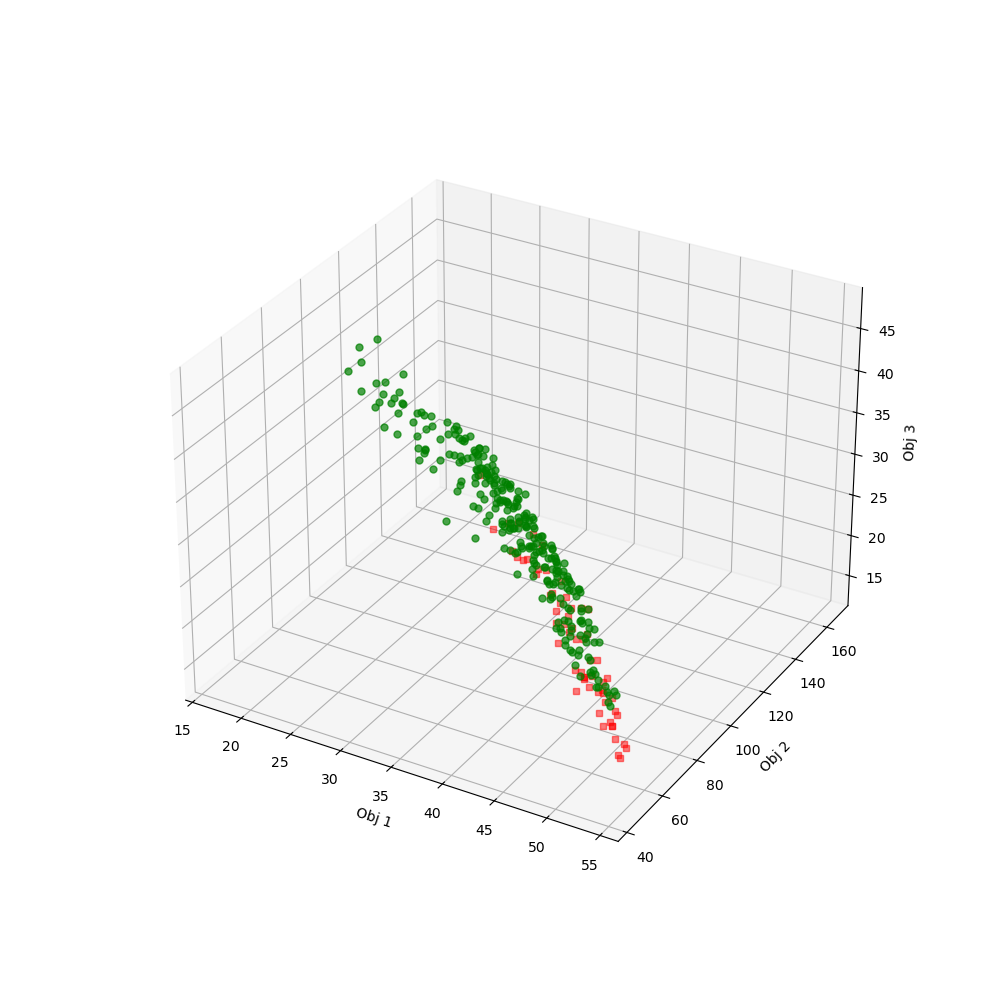

In [207]:
from matplotlib import pyplot as plt
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(converged_pf[:,0], converged_pf[:,1], converged_pf[:,2], 'rs', alpha=0.5, markersize=5)
ax.plot(converged_pf_full[:,0], converged_pf_full[:,1], converged_pf_full[:,2], 'go', alpha=0.7, markersize=5)
ax.set_xlabel('Obj 1')
ax.set_ylabel('Obj 2')
ax.set_zlabel('Obj 3')
plt.show()

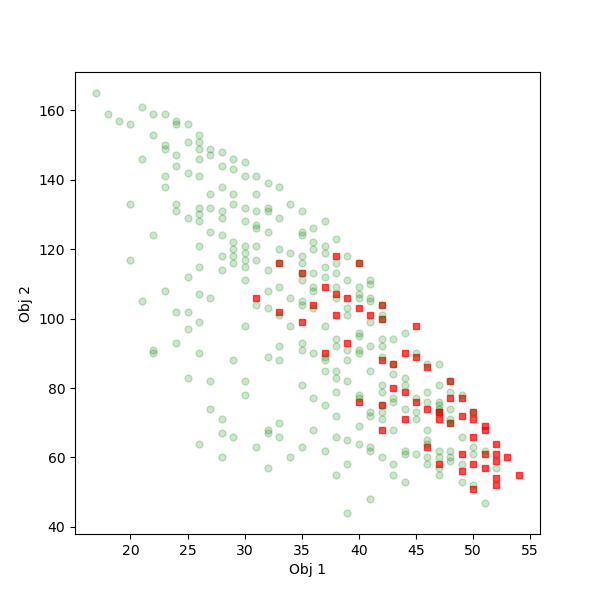

In [208]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.plot(converged_pf[:,0], converged_pf[:,1], 'rs', alpha=0.7, markersize=5)
ax.plot(converged_pf_full[:,0], converged_pf_full[:,1], 'go', alpha=0.2, markersize=5)
ax.set_xlabel('Obj 1')
ax.set_ylabel('Obj 2')
plt.show()

In [209]:
from pymoo.indicators.hv import HV
A = converged_pf[:,0:n_obj].astype(np.float64)
B = converged_pf_full[:,0:n_obj].astype(np.float64)
A_min = -A
B_min = -B

# worst_min = np.max(np.vstack([A_min, B_min]), axis=0)
# ref = worst_min * 1.05
ref = np.array([0.0, 0.0, 0.0])
hv = HV(ref_point=ref)

A_hv = hv(A_min)
B_hv = hv(B_min)

print(A_hv)
print(B_hv)
print((A_hv-B_hv)/B_hv)

170276.0
268360.0
-0.3654941123863467


In [210]:
pf_predicted = converged_pf[:, 0:n_obj]
pf_actual = converged_pf_full[:, 0:n_obj]
dominated = np.zeros(len(pf_predicted))
for i in range(len(pf_predicted)):
    for j in range(len(pf_actual)):
        if np.all(pf_actual[j, :n_obj] >= pf_predicted[i, :n_obj]) and \
            np.any(pf_actual[j, :n_obj] > pf_predicted[i, :n_obj]):
            dominated[i] = 1
            break
np.sum(dominated)/len(pf_predicted)

0.7833333333333333

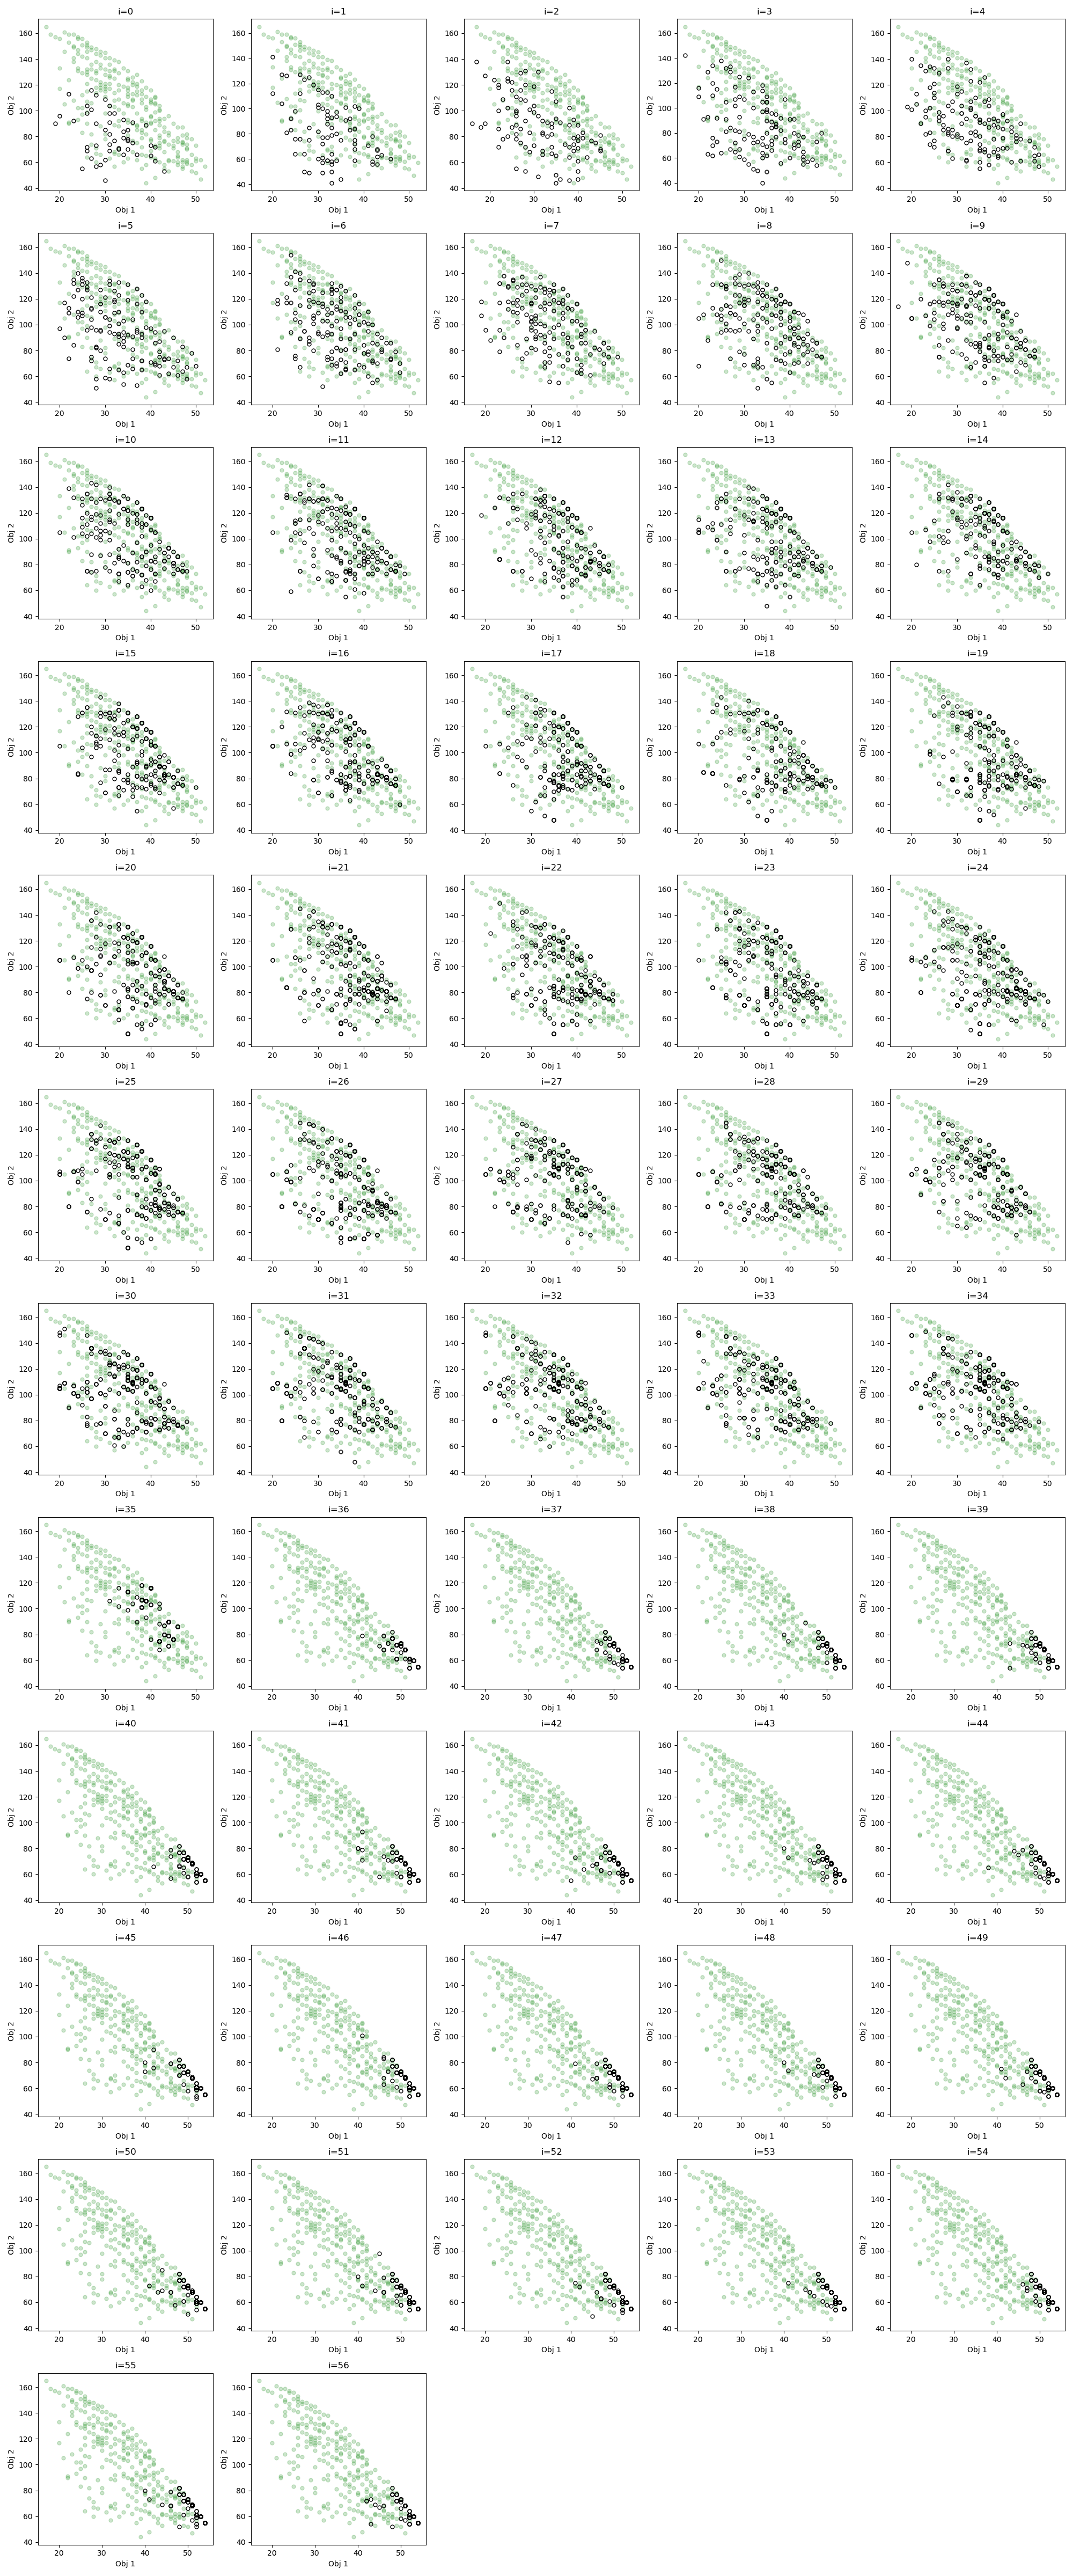

In [211]:
# import math
# import matplotlib.pyplot as plt

n_plots = len(results['pareto_front_table']) 
cols = 5
rows = math.ceil(n_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
axes = np.atleast_1d(axes).ravel()

for k, i in enumerate(range(len(results['pareto_front_table']))):
    ax = axes[k]

    # ax.plot(converged_pf[:,0].copy(),      converged_pf[:,1].copy(),      'rs', alpha=0.7, markersize=5)
    ax.plot(converged_pf_full[:,0].copy(), converged_pf_full[:,1].copy(), 'go', alpha=0.2, markersize=5)

    pf = results['pareto_front_table'][i]
    ax.plot(pf[:,0].copy(), pf[:,1].copy(), marker='o', linestyle='None',
        markerfacecolor='none', markeredgecolor='k',
        markersize=5)

    ax.set_title(f"i={i}")
    ax.set_xlabel("Obj 1")
    ax.set_ylabel("Obj 2")

for ax in axes[n_plots:]:
    ax.axis("off")

plt.tight_layout()
plt.show()